# Understanding time series

The content of this notebook is based on examples related to chapter 4 of the book ["Machine Learning for Finance"](https://www.packtpub.com/product/machine-learning-for-finance/9781789136364) written by Jannes Klaas.

Outline:
1. [Load the dataset](#Section-1-Load-the-dataset)
1. [EDA](#Section-2-EDA)
1. [Examining the sample time series](#Section-3-Examining-the-sample-time-series)
1. [Fast Fourier transformations](#Section-4.-Fast-Fourier-transformations)
1. [Autocorrelation](#Section-5.-Autocorrelation)
1. [Establishing a training and testing regime](#Section-6.-Establishing-a-training-and-testing-regime)

We will work the traffic data from Wikipedia. Our goal will be to forecast traffic for a specific Wikipedia page. We can obtain the Wikipedia traffic data bia the `wikipediatrend` CRAN package.

The dataset that we are going to use here  si the traffic data and counts around 145,00 Wikipedia pages that has been provided by Google. The data can be found at the following links: https://www.kaggle.com/c/web-traffic-time-series-forecasting, or https://www.kaggle.com/muonneutrino/wikipedia-trafficdata-exploration

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import scipy.stats as stats
from statsmodels.tsa.arima_model import ARIMA
from scipy.fftpack import fft
from typing import Dict, Tuple, List, Union
import pandas as pd
from pandas.core.frame import DataFrame, Series
import matplotlib.pyplot as plt
import numpy as np
from numpy.core import ndarray, int64, float64
from datetime import datetime
import os
import sys
import inspect
plt.style.use('default')

Here, we import modules from parent folder in Python.

In [2]:
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 
import utils
import config

## Section 1 Load the dataset

In [3]:
datapaths: Dict[str, str] = config.datapaths['tsa']

train: DataFrame = pd.read_csv(datapaths['train_1'])
train

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145058,Underworld_(serie_de_películas)_es.wikipedia.o...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,13.0,12.0,13.0,3.0,5.0,10.0
145059,Resident_Evil:_Capítulo_Final_es.wikipedia.org...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145060,Enamorándome_de_Ramón_es.wikipedia.org_all-acc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145061,Hasta_el_último_hombre_es.wikipedia.org_all-ac...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


We no longer have to make further investigations to notice that there are missing values denoted `NaN` in our dataset. We also notice that there is one column  of dtype `object`, while the rest is of dtype `float64`. Meaning that `NaN` values are encoded as `numpy.float64`.

While most time series work is focused on local, time-dependent features, we can enrich all of our models by providing access to **global features**. Therefore, we want to split up the page string into smaller, more useful features. To achieve this, we create the `parse_page` function.

In [5]:
def parse_page(page: str) -> Tuple[str, str, str, str]:
    '''Create global features from a Page sample.'''
    x: List[str] = page.split('_')
    
    # The name of the page could also include underscores
    page_name: str = ' '.join(x[:-3])
    
    sub_url: str = x[-3]
    access: str = x[-2]
    agent: str = x[-1]
    
    return page_name, sub_url, access, agent

In [6]:
global_features: Series = train.Page.apply(parse_page)
global_features.head()

0         (2NE1, zh.wikipedia.org, all-access, spider)
1          (2PM, zh.wikipedia.org, all-access, spider)
2           (3C, zh.wikipedia.org, all-access, spider)
3      (4minute, zh.wikipedia.org, all-access, spider)
4    (52 Hz I Love You, zh.wikipedia.org, all-acces...
Name: Page, dtype: object

In [7]:
new_column_names: List[str] = ['subject', 'sub_url', 'access', 'agent']

for i, colname in enumerate(new_column_names):
    train[colname] = global_features.str.get(i)

train.drop('Page', axis=1, inplace=True)

Utilizing the `info` method below, we now notice that the new columns we added to our initial dataset are of dtype `object`. It would be better to encode them as being categories.

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 554 entries, 2015-07-01 to agent
dtypes: float64(550), object(4)
memory usage: 613.1+ MB


In [9]:
train[new_column_names] = train[new_column_names].astype('category')

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 554 entries, 2015-07-01 to agent
dtypes: category(4), float64(550)
memory usage: 611.3 MB


Eventually, we end up with our full dataset. Meaning, that we are now ready to move on the EDA (Explanatory Data Analysis).

In [11]:
N, D = train.shape

train

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,subject,sub_url,access,agent
0,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,...,14.0,20.0,22.0,19.0,18.0,20.0,2NE1,zh.wikipedia.org,all-access,spider
1,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,...,9.0,30.0,52.0,45.0,26.0,20.0,2PM,zh.wikipedia.org,all-access,spider
2,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,...,4.0,4.0,6.0,3.0,4.0,17.0,3C,zh.wikipedia.org,all-access,spider
3,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,...,16.0,11.0,17.0,19.0,10.0,11.0,4minute,zh.wikipedia.org,all-access,spider
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,11.0,27.0,13.0,36.0,10.0,52 Hz I Love You,zh.wikipedia.org,all-access,spider
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.0,12.0,13.0,3.0,5.0,10.0,Underworld (serie de películas),es.wikipedia.org,all-access,spider
145059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Resident Evil: Capítulo Final,es.wikipedia.org,all-access,spider
145060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Enamorándome de Ramón,es.wikipedia.org,all-access,spider
145061,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Hasta el último hombre,es.wikipedia.org,all-access,spider


## Section 2 EDA

We can now create some aggregate statistics on global features.

First, let's plot the distribution of global features.

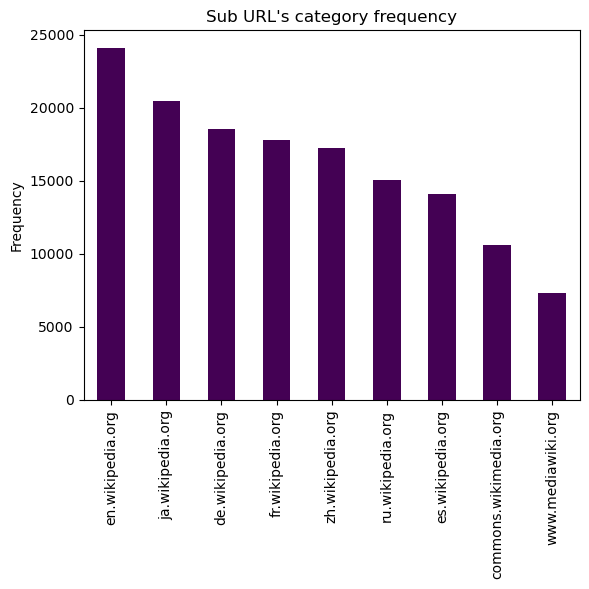

In [12]:
train.sub_url.value_counts().plot(kind='bar', cmap=plt.cm.viridis)
plt.title('Sub URL\'s category frequency')
plt.ylabel('Frequency')
plt.show()

The preceding plot shows the number of time series available for each subpage.

Wikipedia has subpages for different languages, and we can see that our dataset contains pages from the English (en), Japanese (ja), German (de), French (fr), Chinese (zh), Russian (ru), and Spanish (es) Wikipedia sites.

In the bar chart we produced you may have also noted two non-country based Wikipedia sites. Both `commons.wikimedia.org` and `www.mediawiki.org` are used to host media files such as images.

Let's run that command again, this time focusing on the type of access:

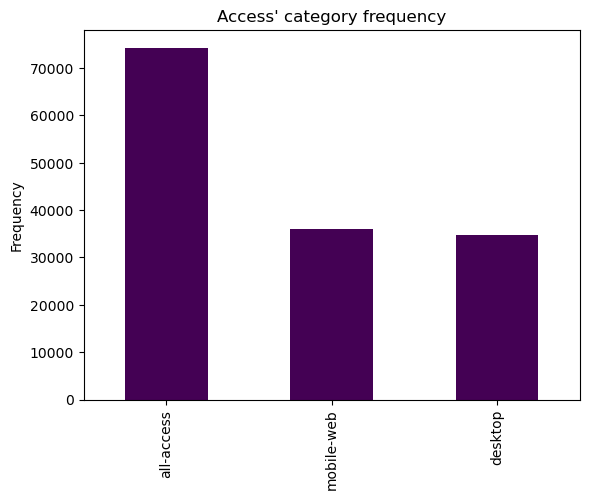

In [13]:
train.access.value_counts().plot(kind='bar', cmap=plt.cm.viridis)
plt.title('Access\' category frequency')
plt.ylabel('Frequency')
plt.show()

There are two possible access methods: **mobile** and **desktop**. There's also a third option **all-access**, which combines the statistics for mobile and desktop access.

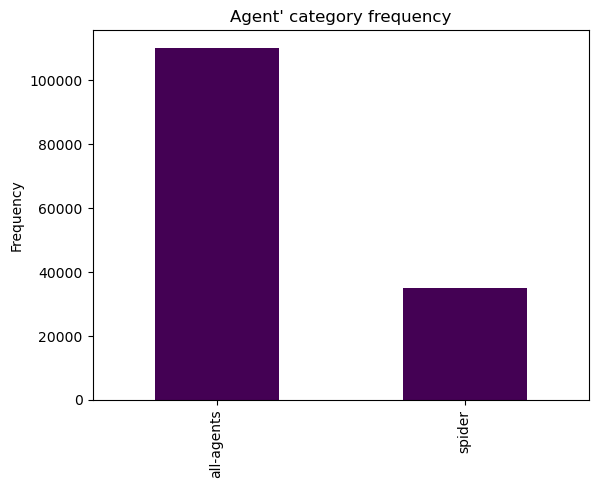

In [14]:
train.agent.value_counts().plot(kind='bar', cmap=plt.cm.viridis)
plt.title('Agent\' category frequency')
plt.ylabel('Frequency')
plt.show()

## Section 3 Examining the sample time series

In classic statistical modeling, the next step would be to analyze the effect of each of these global features and build models around them. However, this is not necessary if there's enough data and computing power available.

If that's the case then a neural network is able to discover the effects of the global features itself and create new features based on their interactions. There are only two real considerations that need to be addressed for global features:
1. Is the distribution of features very skewed?
    * Our distribution is relatively even, so we do not have to worry about this
1. Can features be easily encoded?
    * The subject names, in our case, cannot be one-hot encoded since there are too many of them

In [15]:
idx: int = 39457
window: int = 10
    
data_features: Series = train.iloc[idx, :-4]
name: str = train.iloc[idx, -4]
days: List[int] = [r for r in range(data_features.shape[0])]
equal_weights: ndarray = np.ones((window, )) / window

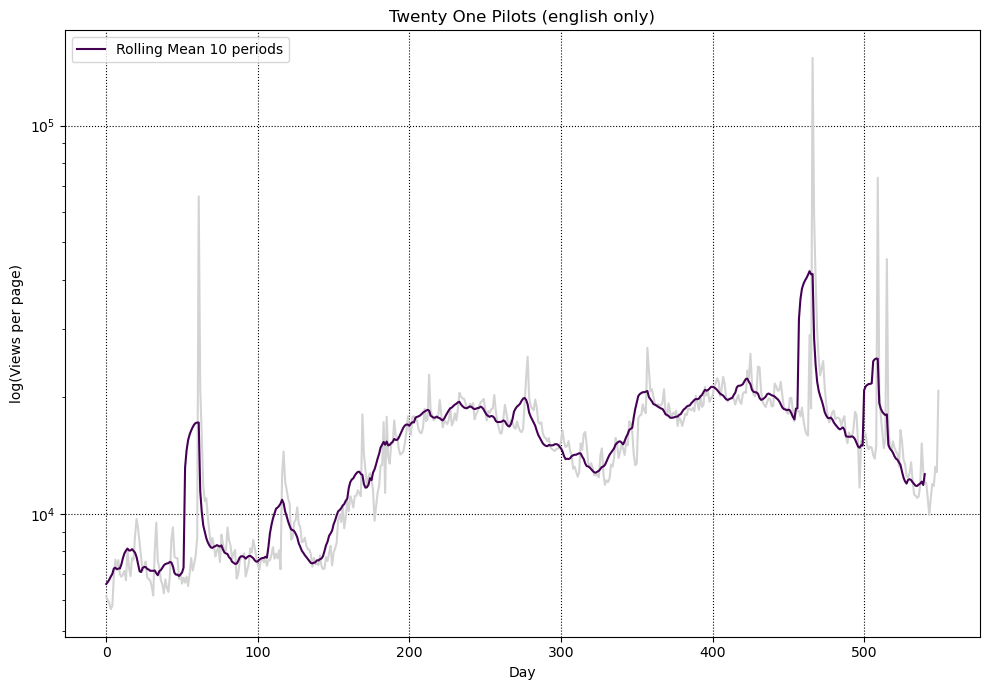

In [16]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(days, data_features, c='lightgray')
ax.plot(np.convolve(data_features, equal_weights, mode='valid'), c=plt.cm.viridis.colors[0], label=f"Rolling Mean {window} periods")
ax.set_yscale('log')
plt.grid(ls=':', c='k')
plt.title(f"{name} (english only)")
plt.ylabel("log(Views per page)")
plt.xlabel('Day')
plt.legend()
plt.tight_layout()
plt.show()

There are two main observations we can make from the plot above:
1. There are **large spikes** and our model will have to deal with them
1. There is a positive overall **trend**

For good measure, let's plot the interest in Twenty One Pilots for all languages.

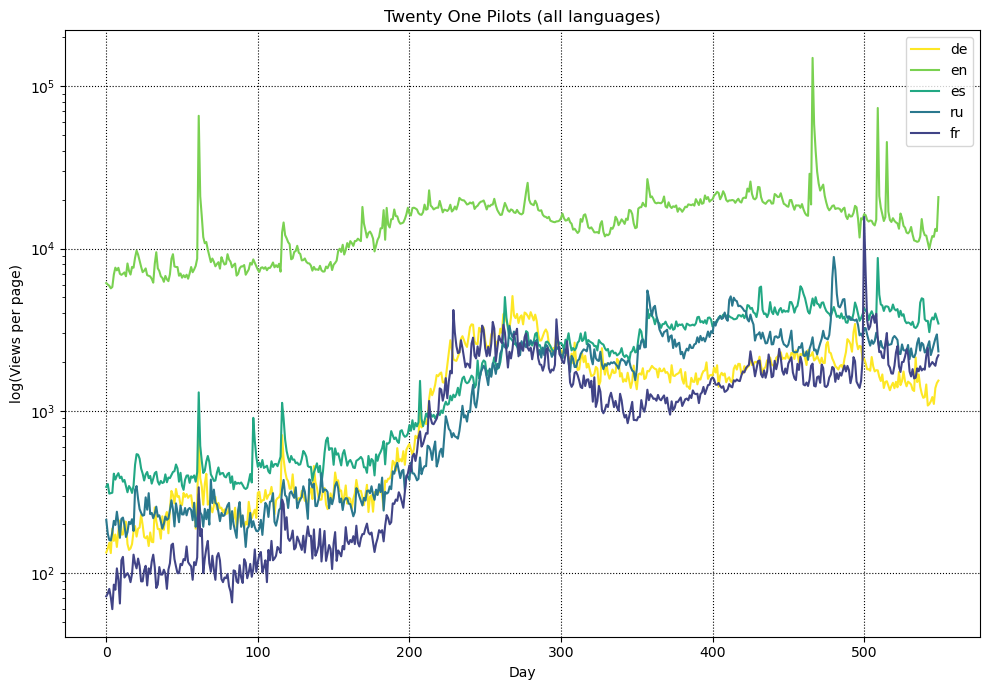

In [17]:
countries: List[str] = ['de', 'en', 'es', 'ru', 'fr']
increment: int = len(plt.cm.viridis.colors) // len(countries)

fig, ax = plt.subplots(figsize=(10, 7))

for i, country in enumerate(countries):
    idx: int64 = np.where((train.subject == name) &  (train.sub_url == f"{country}.wikipedia.org") & 
                        (train.access == "all-access") & (train.agent == "all-agents"))[0][0]
    sample: Series = train.iloc[idx, :-4]
    ax.plot(days, sample, label=country, c=plt.cm.viridis_r.colors[i * increment])
ax.set_yscale('log')
plt.grid(ls=':', c='k')
plt.title(f"{name} (all languages)")
plt.ylabel("log(Views per page)")
plt.xlabel('Day')
plt.legend()
plt.tight_layout()
plt.show()

Observations:
* There is clearly some **correlation** between the time series
* The English language version of Wikipedia (the top line) is, not surprisingly, by far the most popular
* The time series in our datasets are clearly **not** stationary, i.e., they change means and standard deviations over time

A **stationary process** is one whose unconditional joint probability distribution stays constant over time. In other words, things such as the series mean or standard deviation should stay constant. 

There are several kinds of stationarity:
* Mean stationary
* Variance stationary
* Covariance stationary

## Section 4. Fast Fourier transformations

In [18]:
samples: DataFrame = train.iloc[:, :-4]
print(f"sample.shape: {samples.shape}")
fft_complex = fft(samples)
fft_mag = [np.sqrt(np.real(x) * np.real(x) + np.imag(x) * np.imag(x)) for x in fft_complex]

sample.shape: (145063, 550)


### Detect frequencies

Here, we first extract the time series measurements without the global features from our training set. Then we run the FFT algorithm, before finally computing the magnitudes of the transformation

In [19]:
fft_arr: ndarray = np.array(fft_mag)
fft_mean_per_frequency: ndarray = np.nanmean(fft_arr, axis=0)
fft_mean_per_frequency.shape

(550,)

In [20]:
n_days: int = fft_mean_per_frequency.shape[0]

fft_xvals = [day / n_days for day in range(n_days)]

npts = len(fft_xvals) // 2 + 1
fft_mean_half_1 = fft_mean_per_frequency[:npts]
fft_xvals_half_1 = fft_xvals[:npts]

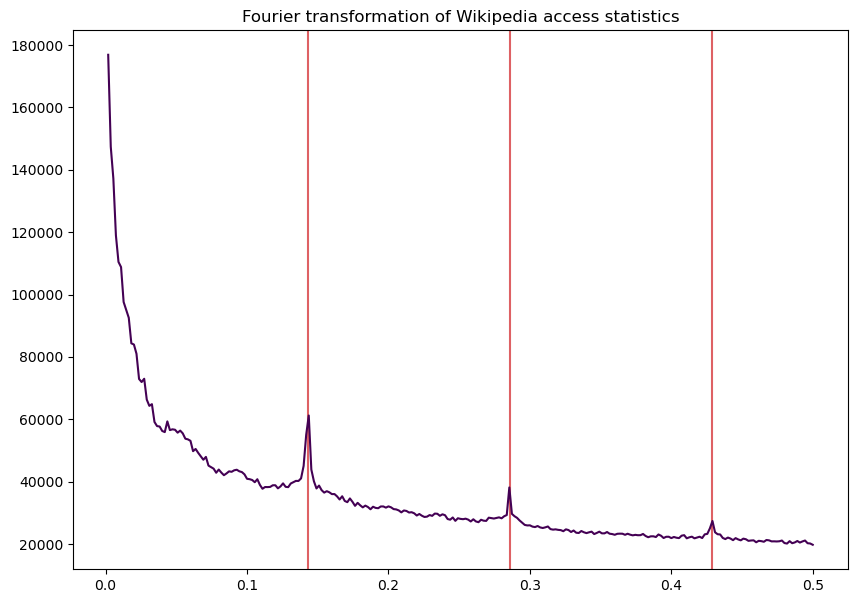

In [21]:
axvline_color = plt.cm.plasma.colors[150]

fig, ax = plt.subplots(figsize=(10, 7))
plt.axvline(x=1./7, color=axvline_color)
plt.axvline(x=2./7, color=axvline_color)
plt.axvline(x=3./7, color=axvline_color)
ax.plot(fft_xvals_half_1[1:], fft_mean_half_1[1:], c=plt.cm.viridis_r.colors[-1])
plt.title('Fourier transformation of Wikipedia access statistics')
plt.show()

As you can see in the chart we produced, there are spikes at roughly 1/7 (0.14), 2/7 (0.28), and 3/7 (0.42). As a week has seven days, that is a frequency of one time per week, two times per week, and three times per week. In other words, page statistics repeat themselves (approximately) every week, so that, for example, access on one Saturday correlates with access on the previous Saturday.

## Section 5. Autocorrelation

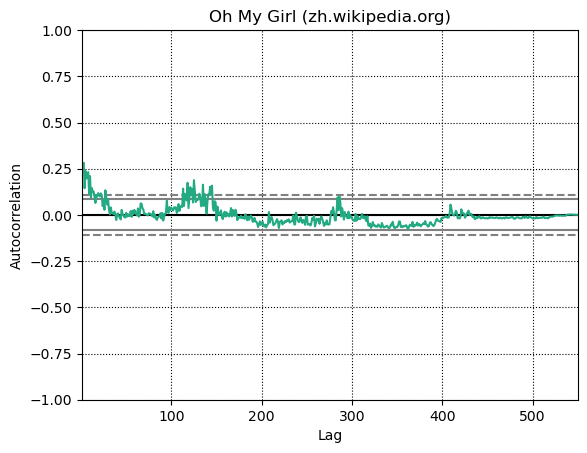

In [22]:
pd.plotting.autocorrelation_plot(samples.iloc[110], c=plt.cm.viridis_r.colors[100])
plt.title(f"{train.loc[110, 'subject']} ({train.loc[110, 'sub_url']})")
plt.grid(ls=':', c='k')
plt.show()

The plot in the preceding chart shows the correlation of page views for the Wikipedia page of *Oh My Girl*, a South Korean girl group, within the Chinese Wikipedia.

You can see that shorter time intervals between 1 and 20 days show a higher autocorrelation than longer intervals. Likewise there are also curious spikes, such as around 120 days and 280 days. It's possible that annual, quarterly, or monthly events could lead to an increase in the frequency of visits to the *Oh My Girl* Wikipedia page.

We can examine the general pattern of these frequencies by drawing 1,000 of these autocorrelation plots.

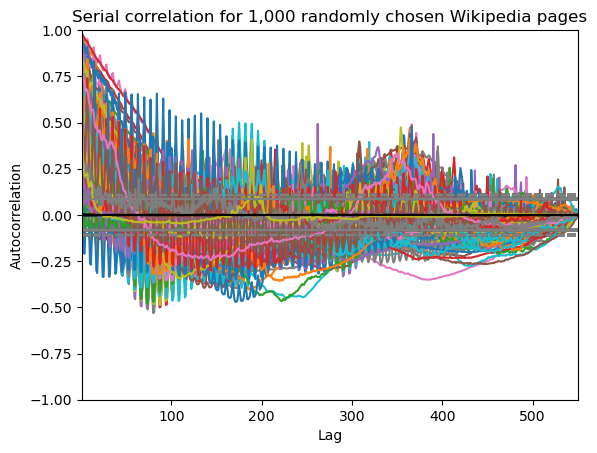

In [23]:
for i in np.random.choice(N, size=1000):
    pd.plotting.autocorrelation_plot(samples.iloc[i])

plt.title('Serial correlation for 1,000 randomly chosen Wikipedia pages')
plt.show()

Observations:
* **Autocorrelations** can be very different depending on the series
* There is a lot of **noise** within the plot
* General trend toward higher autocorrelations at around the 250-day mark attesting for probable yearly autocorrelation

## Section 6. Establishing a training and testing regime
We will use the *side-by-side* splitting approach for the validation set.

In [24]:
X: DataFrame = samples.iloc[:, :500]
y: DataFrame = samples.iloc[:, 500:]
print(f"X.shape = {X.shape}, and y.shape = {y.shape}")

X.shape = (145063, 500), and y.shape = (145063, 50)


In [25]:
X_train, X_val, y_train, y_val = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.1, random_state=42)
print(f"X_train.shape = {X_train.shape}, X_val.shape = {X_val.shape}, y_train.shape = {y_train.shape}, and y_val.shape = {y_val.shape}")

X_train.shape = (130556, 500), X_val.shape = (14507, 500), y_train.shape = (130556, 50), and y_val.shape = (14507, 50)


In [26]:
def mape(y_true, y_pred):
    '''MAPE (Mean Absolute Percentage Error).'''
    epsilon: int = 1
    return np.nanmean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

## Section 7. Median forecasting

In [27]:
lookback: int = 50
lb_data = X_train[:, -lookback:]

# For each sample it take the median of the periods
med: ndarray = np.median(lb_data, axis=1, keepdims=True)

err = mape(y_train, med)
print(f"The MAPE for median forecasting is {np.round(err, decimals=2)}%")

The MAPE for median forecasting is 62.9%


In [28]:
med.shape

(130556, 1)

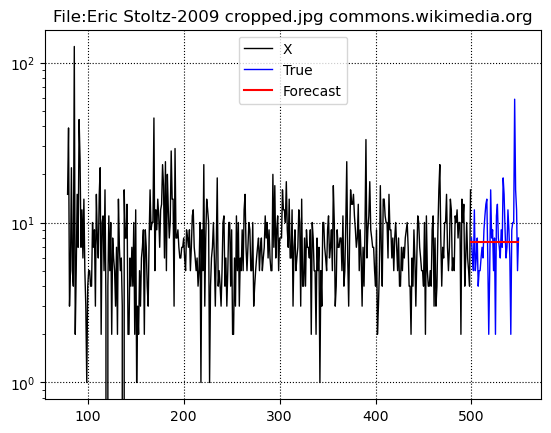

In [29]:
idx: int = 15000
lw: float = 1.

fig, ax = plt.subplots()
ax.plot(np.arange(500), X_train[idx], label='X', lw=lw, c='k')
ax.plot(np.arange(500, 550), y_train[idx], label='True', lw=lw, c='b')
ax.plot(np.arange(500, 550), np.repeat(med[idx], 50), label='Forecast', c='r')
plt.title(' '.join(train.loc[idx, ['subject', 'sub_url']]))
ax.legend()
ax.set_yscale('log')
plt.grid(ls=':', c='k')
plt.show()

## Section 8. ARIMA
In our case we want to include 5 lags, differentiate our series once, and take a moving average winodw of 5.

In [30]:
model = ARIMA(np.nan_to_num(X_train[0]), order=(5, 1, 5))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  499
Model:                 ARIMA(5, 1, 5)   Log Likelihood               -3864.353
Method:                       css-mle   S.D. of innovations            554.901
Date:                Tue, 29 Sep 2020   AIC                           7752.705
Time:                        18:45:21   BIC                           7803.257
Sample:                             1   HQIC                          7772.543
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0501     15.544      0.196      0.844     -27.415      33.515
ar.L1.D.y     -0.0930      0.040     -2.335      0.020      -0.171      -0.015
ar.L2.D.y     -0.6624      0.033    -20.099      0.000      -0.727      -0.598
ar.L3.D.y     -0.5104      0.052     -9.780      0.000      -0.613      -0.408
ar.L4.D.y     -0.2225      0.032     -6.913      0.000      -0.286      -0.159
ar.L5.D.y     -0.8554      0.040    -21.494      0.000      -0.933      -0.777
ma.L1.D.y     -0.1237      0.052     -2.364      0.018      -0.226      -0.021
ma.L2.D.y      0.3654      0.044      8.278      0.000       0.279       0.452
ma.L3.D.y      0.4518      0.051      8.812      0.000       0.351       0.552
ma.L4.D.y     -0.2619      0.045     -5.789      0.000      -0.351      -0.173
ma.L5.D.y      0.6590      0.045     14.766      0.000       0.572       0.746
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6363           -0.7875j            1.0124           -0.1418
AR.2            0.6363           +0.7875j            1.0124            0.1418
AR.3           -1.0942           -0.0000j            1.0942           -0.5000
AR.4           -0.2192           -0.9971j            1.0210           -0.2844
AR.5           -0.2192           +0.9971j            1.0210            0.2844
MA.1           -1.0230           -0.0000j            1.0230           -0.5000
MA.2           -0.0932           -1.0750j            1.0790           -0.2638
MA.3           -0.0932           +1.0750j            1.0790            0.2638
MA.4            0.8034           -0.7927j            1.1287           -0.1239
MA.5            0.8034           +0.7927j            1.1287            0.1239
-----------------------------------------------------------------------------
"""

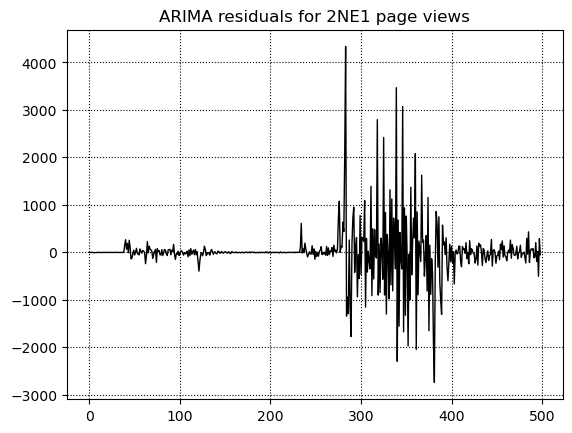

In [31]:
residuals: DataFrame = pd.DataFrame(model.resid)
plt.plot(residuals, c='k', lw=1)
plt.title('ARIMA residuals for 2NE1 page views')
plt.grid(ls=':', c='k')
plt.show()

Observations:
* The model does very well in the beginning
* But it does bad between the 250 to 400-day time laps

This could be because page views are harder to predict or because there is more volatility in this period.

We need to check the **skewness** of our **residuals**. We can do this by plotting a **kernel density estimator**, which is a mathematical method designed to estimate distributions without needing to model them.

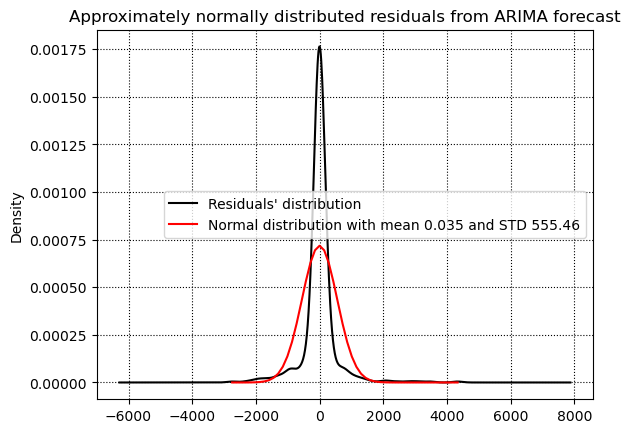

In [32]:
x = np.linspace(residuals.min(), residuals.max())
residuals.plot(kind='kde', c='k')
plt.plot(x, stats.norm.pdf(x, residuals.mean(), residuals.std()), c='r')
plt.title('Approximately normally distributed residuals from ARIMA forecast')
plt.grid(c='k', ls=':')
plt.legend(labels=['Residuals\' distribution', f'Normal distribution with mean {np.round(residuals.mean()[0], decimals=3)} and STD {np.round(residuals.std()[0], decimals=3)}'])
plt.show()

In [33]:
predictions, stderr, conf_int = model.forecast(50)

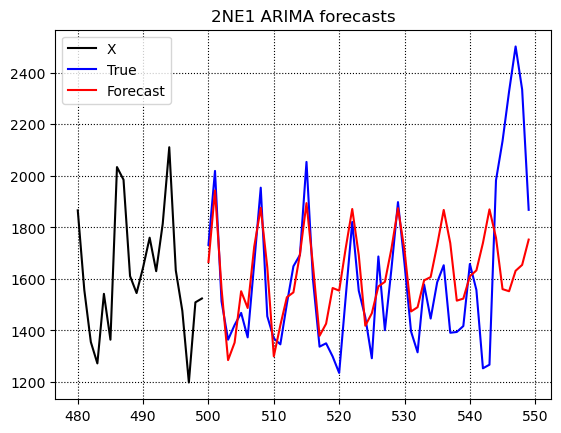

In [34]:
fig, ax = plt.subplots()
ax.plot(np.arange(480, 500), X_train[0, 480:], label='X', c='k')
ax.plot(np.arange(500, 550), y_train[0], label='True', c='b')
ax.plot(np.arange(500, 550), predictions, label='Forecast', c='r')
plt.title('2NE1 ARIMA forecasts')
plt.grid(c='k', ls=':')
ax.legend()
plt.show()

ARIMA captures the periodicity of the series very well. Its forecast does steer off a bit toward the end, but in the beginning, it does a remarkable job.

## Section 8 Forecasting with neural networks
### Subsection 8.1 Weekdays

As the day of the week matters, because of behavioural reasons (e.g., people behave differently on Sundays than on Mondays when browsing), we need to create categorical variables from the dates of our dataset. 

First, let's retrieve the weekday name of each date:

In [35]:
weekdays: List[str] = [datetime.strptime(date, '%Y-%m-%d').strftime('%a') for date in samples.columns.to_numpy()]
weekdays[:5]

['Wed', 'Thu', 'Fri', 'Sat', 'Sun']

We can also create a function to achieve this:

In [36]:
def get_weekdays(series: Series, start: int, end: int) -> List[str]:
    '''Get weekday names from a series with dates in its columns.'''
    return [datetime.strptime(date, '%Y-%m-%d').strftime('%a') for date in series.iloc[:, start:end].columns.to_numpy()]

Then, we encode the strings into integers:

In [37]:
day_one_hot: ndarray = LabelEncoder().fit_transform(weekdays)
day_one_hot[:5]

array([6, 4, 0, 2, 3], dtype=int64)

We also need to reshape our numpy array such that the OneHotEconder understands that we are working with one feature, and not the other way around:

In [38]:
day_one_hot = day_one_hot.reshape(-1, 1)
day_one_hot.shape

(550, 1)

We now can one-hot encode our array:

In [39]:
day_one_hot = OneHotEncoder(sparse=False).fit_transform(day_one_hot)
day_one_hot

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

Notice that we passed `False` to the `sparse` parameter in order to specify the type of the output being a NumPy array and not a Sparse Matrix.

In [40]:
day_one_hot.shape

(550, 7)

Finally, we one-hot encode the days. We then add a new dimension to the tensor showing that we only have one "row" of dates

In [41]:
day_one_hot = np.expand_dims(day_one_hot, 0)
day_one_hot.shape

(1, 550, 7)

### One-hot encode global features

In [42]:
def one_hot_encode_series(series: Series) -> ndarray:
    '''One-hot encode series.'''
    encoded_series: ndarray = LabelEncoder().fit_transform(series).reshape(-1, 1)
    one_hot_series: ndarray = OneHotEncoder(sparse=False).fit_transform(encoded_series)
    return one_hot_series    

In [43]:
one_hot_features: Dict[str, ndarray] = dict()

In [44]:
for feature in train.columns[-3:]:
    one_hot_features[feature] = one_hot_encode_series(train[feature])

### Lagged features

Now we come to the lagged features. Technically, neural networks could discover what past events are relevant for forecasting themselves. However, this is pretty difficult because of the vanishing gradient problem.

In [45]:
def lagged_features(features_tensor: ndarray, num_lags: int, fill_value: Union[int, float] = np.nan) -> ndarray:
    '''Creates a tensor of lagged features and appends them to it.
    
    Parameters
    ----------
    features_tensor : numpy.ndarray
        NumPy array of feature data with shape (N, T, D=1), where
        N is the number of samples, T is the period-window size, and D 
        is the number of features.
    
    num_lags : int
        The number of lags to be generated.
    
    fill_value : Union[int, float]
        The values the lag vector should be filled of when being shifted.
        
    Returns
    -------
    numpy.ndarray
        Extended features' tensor with its lags.
    '''
    N, T, D = features_tensor.shape  # D = 1
    filled = np.full((N, num_lags, D), fill_value)
    extended_feature = np.concatenate((filled, features_tensor), axis=1)
    return extended_feature[:, :T]    

In the following function, we will define this equation: $$ R(\tau) = \frac{\Sigma \left[(X_t - \mu_t) (X_{t+\tau} - \mu_{t+\tau})\right]}{\sigma_t \sigma_{t+\tau}} $$

In [46]:
def single_autocorr(series: ndarray, num_lags: int) -> float64:
    '''Computes the autocorrelation between the series and its t-lagged version.
    
    Parameters
    ----------
    series : numpy.ndarray
        Time series.
    
    num_lags : int
        Number of lags.
        
    Returns
    -------
    np.float64
        The serial correlation of the series.
    '''
    
    x0 = series[num_lags:]
    x1 = series[:-num_lags]
    mu0 = np.nanmean(x0)
    mu1 = np.nanmean(x1)
    dx0 = x0 - mu0
    dx1 = x1 - mu1
    sigma0 = np.sqrt(np.nansum(dx0 * dx0))
    sigma1 = np.sqrt(np.nansum(dx1 * dx1))
    return np.nansum(dx0 * dx1) / (sigma0 * sigma1) if (sigma0 * sigma1) != 0 else 0

In [47]:
def batch_autocorr(data: ndarray, num_lags: int, lookback_window: int, verbose: bool = True) -> ndarray:
    '''Create a batch of autocorrelation features.
    
    Parameters
    ----------
    data : numpy.ndarray
        Multiple time series, where rows are samples, and columns are time periods.
        Shape is (N, T).
    
    num_lags : int
        Number of lags.
    
    lookback_window : int
        The lookback rolling window's length.
    
    Returns
    -------
    autocorrs : numpy.ndarray
        A vector containing autocorrelations of each series of the data for 
        a given number of lags and a given lookback rolling window.
        Output shape is (N*lookback_window,).
    '''
    N, D = data.shape
    
    collect_autocorrs: List[float64] = []
    for i in range(N):
        if verbose:
            if i % 10 == 0:
                print(f"Series {i}/{N}")
        r = single_autocorr(data[i, :], num_lags)
        collect_autocorrs.append(r)
        
    autocorrs: ndarray = np.array(collect_autocorrs).reshape(-1, 1)  # Shape: (N, 1)
    autocorrs = np.expand_dims(autocorrs, -1)  # Shape: (N, 1, 1)
    
    # Propagate the autocorrelation
    autocorrs = np.repeat(autocorrs, lookback_window)   # Shape: (N*lookback_window,)
    return autocorrs    

In [48]:
lb = 10
dt = train.iloc[:100, 1:lb+1].to_numpy()
dt.shape

(100, 10)

Running the following code may display a warning: `RuntimeWarning: Mean of empty slice`. We can ignore it. It just tells us that when computing a mean of a series, there were only nan values.

In [49]:
acorrs = batch_autocorr(dt, 5, lb, verbose=False)

Series 0/100
Series 10/100
Series 20/100
Series 30/100
Series 40/100
Series 50/100
Series 60/100
Series 70/100
Series 80/100
Series 90/100


C:\Users\YBant\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
C:\Users\YBant\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice


In [50]:
acorrs.shape

(1000,)

In [51]:
def one_hot_and_dims(series: Series, lookback_window: int) -> ndarray:
    '''One-hot encode features and expand dimensions.'''
    encoded_series: ndarray = one_hot_encode_series(series)
    encoded_series: ndarray = np.expand_dims(encoded_series, 1)
    encoded_series: ndarray = np.repeat(encoded_series, lookback_window, axis=1)
    return encoded_series

In [52]:
def get_batch(time_series: DataFrame, global_features: DataFrame = None, start: int = 0, lookback_window: int = 100, lags: tuple = None) -> tuple:
    '''Create batch of data'''
    N, T = time_series.shape
    
    end: int = start + lookback_window
    assert end <= T,  f"End of lookback out of bounds. End of lookback: {end}, but end of your time series: {T}."
    
    series: ndarray = time_series.iloc[:, start:end].to_numpy()
    target: ndarray = np.log1p(time_series.iloc[:, end].to_numpy())
    
    log_series: ndarray = np.log1p(series)  # Shape: (N, lookback_window)
    log_series = np.expand_dims(log_series, axis=-1)  # Shape: (N, lookback_window, 1)
    
    weekdays: List[str] = get_weekdays(time_series, start, end)
    days_one_hot: ndarray = one_hot_encode_series(weekdays)  # Shape: (lookback_window, 7)
    days_one_hot = np.expand_dims(days_one_hot, 0)  # Shape: (1, lookback_window, 7)
    days: ndarray = np.repeat(days_one_hot, repeats=N, axis=0)  # Shape: (N, lookback_window, 7)
        
    batch: ndarray = np.concatenate((log_series, days), axis=2)  # Shape: (N, lookback_window, 8)
    
    if lags is not None:
        for lag in lags:
            batch = np.concatenate((batch, lagged_features(log_series, lag, np.nan)), axis=2)
    
    if global_features is not None:
        N_, D = global_features.shape
        assert N == N_, ("'time_series' and 'global_features' must have same number of samples."
                         + f" You gave {N} samples for 'time_series', but {N_} for 'global_features'.")
        
        for feature in global_features.columns:
            batch = np.concatenate((batch, one_hot_and_dims(global_features[feature], lookback_window)), axis=2)
        
    return batch, target 

In [53]:
b, t = get_batch(samples, train.iloc[:, -3:], lags=(365, 182, 91))

In [54]:
b.shape

(145063, 100, 25)